In [2]:
import numpy as np
import pandas as pd
np.random.seed(0)

# Read file
X_train_pd = pd.read_csv('./X_train')
Y_train_pd = pd.read_csv('./Y_train')
X_test_pd = pd.read_csv('./X_test')
X_train_pd = X_train_pd.iloc[:, 1:]
Y_train_pd = Y_train_pd.iloc[:, 1:]
X_test_pd = X_test_pd.iloc[:, 1:]

X_train = X_train_pd.to_numpy(dtype = float)
Y_train = Y_train_pd.to_numpy(dtype = float)
Y_train = Y_train.reshape(len(Y_train),)
X_test = X_test_pd.to_numpy(dtype = float)


# Normalization
def normalize(X):
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0)
    for i in range(len(X)):
        for j in range(len(X[0])):
            X[i, j] = (X[i, j] - X_mean[j]) / ( X_std[j] + 1e-8)
    return X

X_train = normalize(X_train)
X_test = normalize(X_test)


# Split data
def data_split(X, Y, test_size = 0.1):
    train_size = int(len(X) * (1 - test_size))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

X_train, Y_train, X_val, Y_val = data_split(X_train, Y_train)
print('X_train:{}, Y_train:{}, X_val:{}, Y_val:{}'.format(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape))

X_train:(48830, 510), Y_train:(48830,), X_val:(5426, 510), Y_val:(5426,)


In [3]:
# Shuffle
def shuffle(X, Y):
    '''Shuffle X / Y indices'''
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]

# Sigmoid (np.clip = limit)
def sigmoid(z):
    '''Sigmoid function'''
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))


def f(X, w, b):
    '''Regression function
    Arguements:
     X: input data, shape = [batch_size, data_dimension]
     w: weight vector, shape = [data_dimension, ]
     b: bias, scalar
    '''
    return sigmoid(np.matmul(X, w) + b)

# 0/1
def predict(X, w, b):
    '''Returns truth value'''
    return np.round(f(X, w, b).astype(np.int))

# Accuracy
def accuracy(Y_pred, Y_label):
    '''Returns accuracy %'''
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

# Cross entropy
def cross_entropy_loss(Y_pred, Y_label):
    '''  Computes cross entropy
         Arguements:
         y_pred: probabilistic predictions, float vector
         Y_label: ground truth labels, bool vector
     Output:
         cross entropy, scalar'''
    cross_entropy = -np.dot(Y_label, np.log(Y_pred)) - np.dot((1-Y_label), np.log(1-Y_pred))
    return cross_entropy

# Gradien descent
def gradient(X, Y_label, w, b):
    '''Computes gradient of cross entropy loss'''
    Y_pred = f(X, w, b)
    pred_error = Y_label - Y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


In [5]:
# Start training
w = np.zeros(X_train.shape[1])
b = np.zeros((1, ))
test_pred = f(X_train, w, b)

# Hyperparameters
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Loss/accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Adaptive learning rates, E.g. 1/t decay: 𝜂^t = 𝜂/(t+1)^1/2
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle
    X_train, Y_train = shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(X_train.shape[0]/batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size, :]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]
        
        # Compute gradient
        w_grad, b_grad = gradient(X, Y, w, b)
        
        # w, b update
        w = w - learning_rate * (w_grad/(np.sqrt(step)))
        b = b - learning_rate * (b_grad/(np.sqrt(step)))
        
        step = step +1
    
    # Compute loss and accuracy of training set and develoment set
    y_train_pred = f(X_train, w, b) # float vector between 0~1
    Y_train_pred = np.round(y_train_pred) # bool vector
    train_loss.append(cross_entropy_loss(y_train_pred, Y_train) / len(X_train))
    train_acc.append(accuracy(Y_train_pred, Y_train))
    
    y_dev_pred = f(X_dev, w, b) # float vector between 0~1
    Y_dev_pred = np.round(y_dev_pred) # bool vector
    dev_loss.append(cross_entropy_loss(y_dev_pred, Y_dev) / len(X_dev))
    dev_acc.append(accuracy(Y_dev_pred, Y_dev))
    
print(' Training loss: {} \n Dev loss: {} \n Training acc: {} \n Dev acc: {} \n'.format(train_loss[-1], dev_loss[-1], train_acc[-1], dev_acc[-1]))


 Training loss: 0.2706029703738686 
 Dev loss: 0.29748356122665576 
 Training acc: 0.8847020274421462 
 Dev acc: 0.8741245853298931 



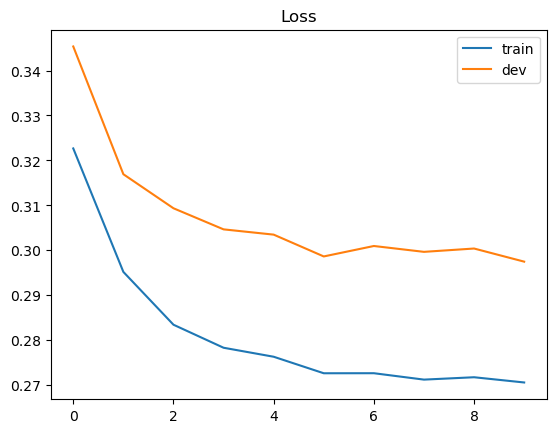

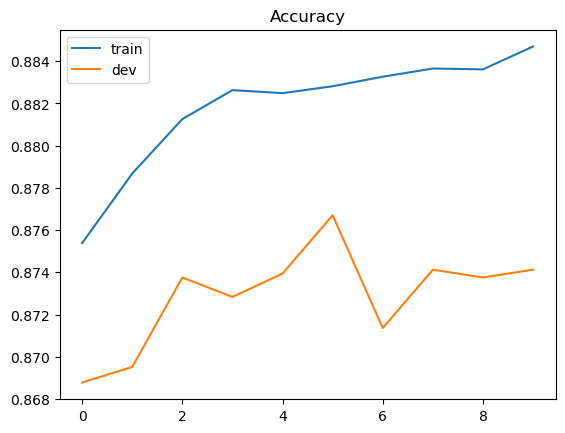

In [6]:
# Plotting
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

Predictions = pd.DataFrame(np.round(f(X_test, w, b)))
Predictions.reset_index(inplace = True)
Predictions.columns = ['id', 'label']
Predictions.to_csv('./X_test_Pred.csv', index = False)